<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AgeStructuredSIRVD-Experiments" data-toc-modified-id="AgeStructuredSIRVD-Experiments-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AgeStructuredSIRVD Experiments</a></span><ul class="toc-item"><li><span><a href="#Models" data-toc-modified-id="Models-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Models</a></span><ul class="toc-item"><li><span><a href="#SIRD" data-toc-modified-id="SIRD-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>SIRD</a></span><ul class="toc-item"><li><span><a href="#UK-Population-Model" data-toc-modified-id="UK-Population-Model-1.1.1.1"><span class="toc-item-num">1.1.1.1&nbsp;&nbsp;</span>UK Population Model</a></span></li></ul></li><li><span><a href="#AgeStructuredSIRD" data-toc-modified-id="AgeStructuredSIRD-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>AgeStructuredSIRD</a></span><ul class="toc-item"><li><span><a href="#UK-Population-Model" data-toc-modified-id="UK-Population-Model-1.1.2.1"><span class="toc-item-num">1.1.2.1&nbsp;&nbsp;</span>UK Population Model</a></span></li></ul></li><li><span><a href="#AgeStructuredSIRVD" data-toc-modified-id="AgeStructuredSIRVD-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>AgeStructuredSIRVD</a></span><ul class="toc-item"><li><span><a href="#UK-Population-Model" data-toc-modified-id="UK-Population-Model-1.1.3.1"><span class="toc-item-num">1.1.3.1&nbsp;&nbsp;</span>UK Population Model</a></span></li><li><span><a href="#UK-Population-Model---with-Superspreaders" data-toc-modified-id="UK-Population-Model---with-Superspreaders-1.1.3.2"><span class="toc-item-num">1.1.3.2&nbsp;&nbsp;</span>UK Population Model - with Superspreaders</a></span></li></ul></li></ul></li></ul></li></ul></div>

# AgeStructuredSIRVD Experiments

In [1]:
%load_ext autoreload
%autoreload 2

from Eir import SIRD, AgeStructuredSIRD, AgeStructuredSIRVD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.style.use("../style.mplstyle")

## Models

### SIRD 

#### UK Population Model

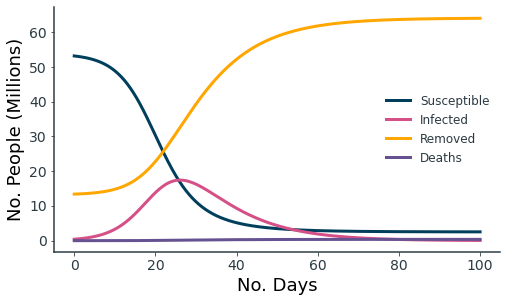

In [3]:
days, dt = 100, 0.1

I0 = 419_000  # assume 1/160 of overall population (67M) currently infected
R0 = 13_400_000  # assume 20% of population (67M) have had COVID-19
S0 = 67_000_000 - I0 - R0  # assume a UK population of 67M. S0 = 67M - I0 - R0
beta = 0.4
gamma = 0.1
omega = 0.00075

sim = SIRD(S0=S0, I0=I0, R0=R0, beta=beta, gamma=gamma, omega=omega)
df = sim.run(days, dt, plot=False)
fig, ax = plt.subplots(figsize=(8, 4.5))
for c in ["Susceptible", "Infected", "Removed", "Deaths"]:
    ax.plot(df["Days"], df[c] / 1000000, label=f"{c}")
    ax.legend()
ax.set_xlabel("No. Days")
ax.set_ylabel("No. People (Millions)")
fig.savefig("../figures/SIRD.png")

In [4]:
print(f"Infection peak: {round(df['Infected'].max()):,}")
sim.end_state().style.format("{:,.2f}")

Infection peak: 17,446,202


,Start_Count,End_Susceptible,Infected_Count,Removed_Count,Deaths_Count,Fatality_Rate%
Overall,"67,000,000.00","2,541,856.00","51,058,144.00","64,015,372.00","379,615.00",0.74


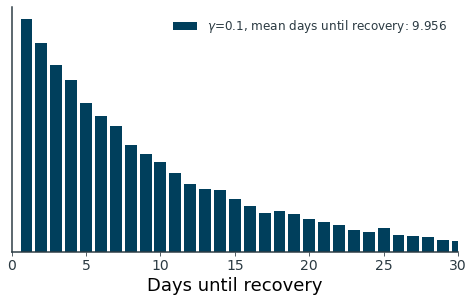

In [5]:
# expected days before recovery
g = 0.1
n_days = []
for _ in range(10_000):
    n = 1
    while True:
        if np.random.random() <= g:
            n_days.append(n)
            break
        else:
            n += 1
counts = pd.Series(n_days).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 4.5))
ax.bar(
    counts.index,
    counts.values,
    label=fr"$\gamma$={g}, mean days until recovery: {np.mean(n_days):.3f}",
)
ax.set_xlim(0, 30)
ax.set_xlabel("Days until recovery")
ax.set_yticks([])
ax.legend()
fig.savefig("../figures/recovery.png")

### AgeStructuredSIRD

#### UK Population Model

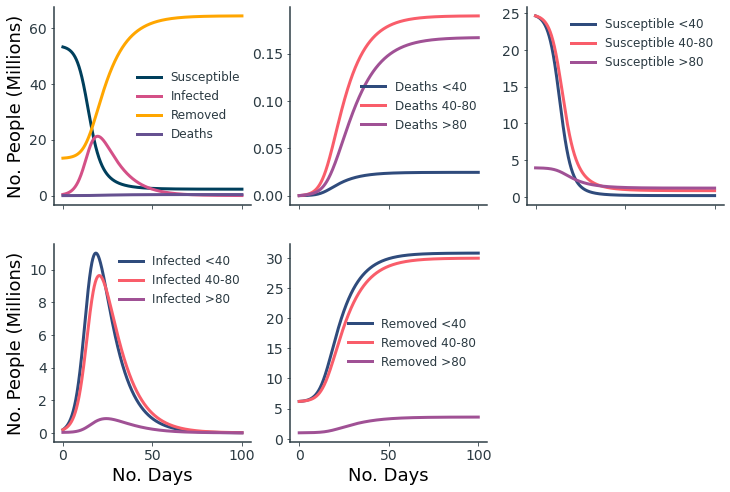

In [6]:
days, dt = 100, 0.1

labels = ["<40", "40-80", ">80"]
I0 = [int(31_000_000 / 160), int(31_000_000 / 160), int(5_000_000 / 160)]
R0 = [int(31_000_000 * 0.2), int(31_000_000 * 0.2), int(5_000_000 * 0.2)]
S0 = [
    int(v)
    for v in np.array([31_000_000, 31_000_000, 5_000_000]) - np.array(I0) - np.array(R0)
]
beta = np.array(
    (
        [
            [0.9, 0.4, 0.1],
            [0.4, 0.5, 0.2],
            [0.1, 0.2, 0.25],
        ]
    )
)
gamma = [0.1, 0.1, 0.1]
omega = [0.0001, 0.0008, 0.0064]

QALYs = [0, 16.62, 7.04, 2.00]  # for Quality Adjusted Life Years analysis

sim = AgeStructuredSIRD(labels, beta, gamma, omega, S0, I0, R0)
df = sim.run(days, dt, plot=False)

fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=False)
ax = ax.flatten()
for a in ax[1:]:  # consume colour map cycle
    a.plot([], [])

for i, c in enumerate(df.columns):
    if i != 0:
        if i < 5:
            ax[0].plot(df["Days"], df[c] / 1000000, label=c.replace("_", " "))
            for a in ax[1:]:  # consume colour map cycle
                a.plot([], [])
        else:
            ax[(i - 4) % 4 + 1].plot(
                df["Days"], df[c] / 1000000, label=c.replace("_", " ")
            )

for i, a in enumerate(ax[:-1]):
    a.legend()
    if i % 3 == 0:
        a.set_ylabel("No. People (Millions)")
    if i in [3, 4]:
        a.set_xlabel("No. Days")
ax[5].remove()
fig.savefig("../figures/AgeStructuredSIRD.png")

In [7]:
print(beta)
pd.DataFrame.from_dict(
    {"S0": S0, "I0": I0, "R0": R0, "gamma": gamma, "omega": omega},
    orient="index",
    columns=labels,
).style.format("{:,}")

[[0.9  0.4  0.1 ]
 [0.4  0.5  0.2 ]
 [0.1  0.2  0.25]]


,<40,40-80,>80
S0,"24,606,250.0","24,606,250.0","3,968,750.0"
I0,"193,750.0","193,750.0","31,250.0"
R0,"6,200,000.0","6,200,000.0","1,000,000.0"
gamma,0.1,0.1,0.1
omega,0.0001,0.0008,0.0064


In [8]:
print(f"Infection peak: {round(df['Infected'].max()):,}")
df_novac = sim.end_state()
df_novac["QALY"] = df_novac["Deaths_Count"] * QALYs
df_novac.iloc[0, -1] = df_novac.iloc[1:, -1].sum()
df_novac

Infection peak: 21,232,468


,Start_Count,End_Susceptible,Infected_Count,Removed_Count,Deaths_Count,Fatality_Rate%,QALY
Combined,67000000,2299964,51300036,64294664,381140,0.743314,2077944.78
<40,31000000,202872,24597128,30765179,24565,0.099899,408270.30
40-80,31000000,873738,23926262,29923430,189787,0.793649,1336100.48
>80,5000000,1223353,2776647,3606054,166787,6.015022,333574.00


### AgeStructuredSIRVD

#### UK Population Model 

##### Young Vaccinated First

          Start_Count  Vaccinated_Count  Deaths_Count  Fatality_Rate%
Combined     67000000           6167286        364791        0.769267
<40          31000000           3238684         21535        0.099897
40-80        31000000           1572610        184291        0.793650
>80           5000000           1355991        158964        6.015011


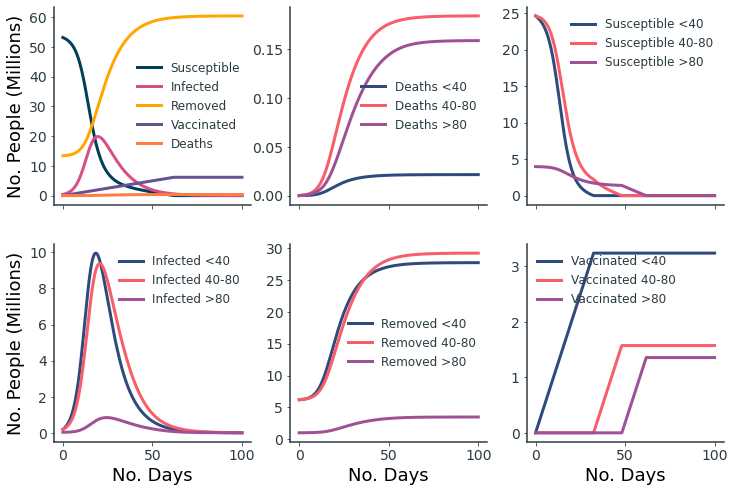

In [9]:
days, dt = 100, 0.1

labels = ["<40", "40-80", ">80"]
I0 = [int(31_000_000 / 160), int(31_000_000 / 160), int(5_000_000 / 160)]
R0 = [int(31_000_000 * 0.2), int(31_000_000 * 0.2), int(5_000_000 * 0.2)]
S0 = [
    int(v)
    for v in np.array([31_000_000, 31_000_000, 5_000_000]) - np.array(I0) - np.array(R0)
]
V0 = [0, 0, 0]
Vd = 100_000
beta = np.array(
    (
        [
            [0.9, 0.4, 0.1],
            [0.4, 0.5, 0.2],
            [0.1, 0.2, 0.25],
        ]
    )
)
gamma = [0.1, 0.1, 0.1]
omega = [0.0001, 0.0008, 0.0064]

sim = AgeStructuredSIRVD(labels, beta, gamma, omega, Vd, S0, I0, R0, V0)
df_yf = sim.run(days, dt, plot=False)
print(
    sim.end_state()[
        ["Start_Count", "Vaccinated_Count", "Deaths_Count", "Fatality_Rate%"]
    ]
)

fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=False)
ax = ax.flatten()
for i, c in enumerate(df_yf.columns):
    if i != 0:
        if i < 6:
            ax[0].plot(df_yf["Days"], df_yf[c] / 1000000, label=c.replace("_", " "))
            for a in ax[1:]:  # consume colour map cycle
                a.plot([], [])
        else:
            ax[(i - 5) % 5 + 1].plot(
                df_yf["Days"], df_yf[c] / 1000000, label=c.replace("_", " ")
            )

for i, a in enumerate(ax):
    a.legend()
    if i % 3 == 0:
        a.set_ylabel("No. People (Millions)")
    if i in [3, 4, 5]:
        a.set_xlabel("No. Days")
fig.savefig("../figures/AgeStructuredSIRVD-young_first.png")

In [10]:
df_end_yf = sim.end_state()
df_end_yf["QALY"] = df_end_yf["Deaths_Count"] * QALYs
df_end_yf.iloc[0, -1] = df_end_yf.iloc[1:, -1].sum()
df_end_yf

,Start_Count,End_Susceptible,Infected_Count,Removed_Count,Vaccinated_Count,Deaths_Count,Fatality_Rate%,QALY
Combined,67000000,0,47432714,60455804,6167286,364791,0.769267,1973248.34
<40,31000000,0,21561316,27735573,3238684,21535,0.099897,357911.70
40-80,31000000,0,23227390,29236406,1572610,184291,0.793650,1297408.64
>80,5000000,0,2644009,3483824,1355991,158964,6.015011,317928.00


##### Old Vaccinated First

          Start_Count  Vaccinated_Count  Deaths_Count  Fatality_Rate%
Combined     67000000           4780060        272300        0.557901
<40          31000000            281055         24488        0.099897
40-80        31000000           1552451        184454        0.793647
>80           5000000           2946553         63356        6.014989


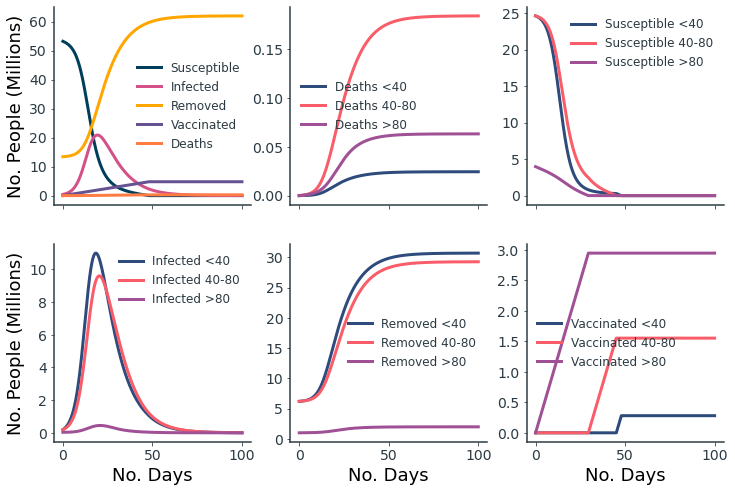

In [11]:
df_of = sim.run(days, dt, reverse_vaccination=True, plot=False)
print(
    sim.end_state()[
        ["Start_Count", "Vaccinated_Count", "Deaths_Count", "Fatality_Rate%"]
    ]
)

fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=False)
ax = ax.flatten()
for i, c in enumerate(df_of.columns):
    if i != 0:
        if i < 6:
            ax[0].plot(df_of["Days"], df_of[c] / 1000000, label=c.replace("_", " "))
            for a in ax[1:]:  # consume colour map cycle
                a.plot([], [])
        else:
            ax[(i - 5) % 5 + 1].plot(
                df_of["Days"], df_of[c] / 1000000, label=c.replace("_", " ")
            )

for i, a in enumerate(ax):
    a.legend()
    if i % 3 == 0:
        a.set_ylabel("No. People (Millions)")
    if i in [3, 4, 5]:
        a.set_xlabel("No. Days")

fig.savefig("../figures/AgeStructuredSIRVD-old_first.png")

In [12]:
df_end_of = sim.end_state()
df_end_of["QALY"] = df_end_of["Deaths_Count"] * QALYs
df_end_of.iloc[0, -1] = df_end_of.iloc[1:, -1].sum()
df_end_of

,Start_Count,End_Susceptible,Infected_Count,Removed_Count,Vaccinated_Count,Deaths_Count,Fatality_Rate%,QALY
Combined,67000000,0,48819940,61935649,4780060,272300,0.557901,1832258.72
<40,31000000,0,24518945,30688827,281055,24488,0.099897,406990.56
40-80,31000000,0,23247549,29256874,1552451,184454,0.793647,1298556.16
>80,5000000,0,1053447,1989946,2946553,63356,6.014989,126712.00


#### UK Population Model - with Superspreaders

Young first:
          Infected_Count  Vaccinated_Count  Deaths_Count  Fatality_Rate%
Combined        23929477          36492096        161287        0.674010
SS                     6              9894             0        0.000000
<40             10487798          20202202         10477        0.099897
40-80           12596499          16280000         99972        0.793649
>80               845175                 0         50837        6.014982

Old first:
          Infected_Count  Vaccinated_Count  Deaths_Count  Fatality_Rate%
Combined        40594925          25744975        171338        0.422068
SS                  9900                 0             9        0.090918
<40             23207343           7482657         23184        0.099899
40-80           17181836          13508164        136363        0.793646
>80               195847           4754153         11780        6.014930


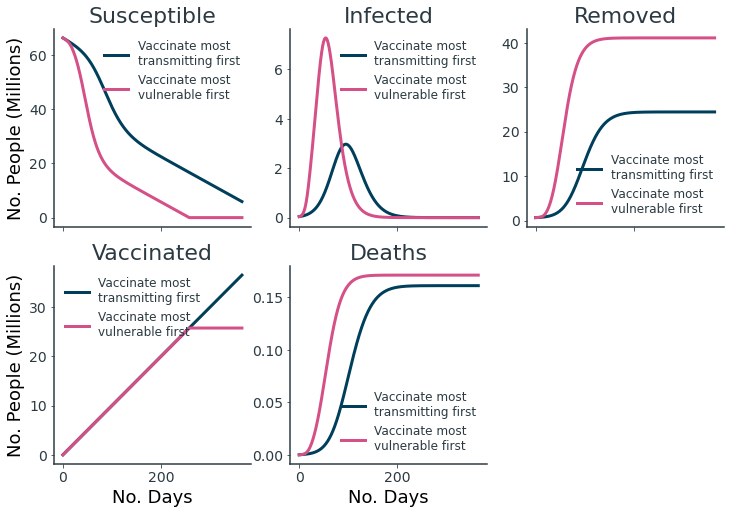

In [13]:
days, dt = 365, 0.1
r = 0.01

labels = ["SS", "<40", "40-80", ">80"]
I0 = [
    int(10_000 / 1600),
    int(31_000_000 / 1600),
    int(31_000_000 / 1600),
    int(5_000_000 / 1600),
]
R0 = [int(10_000 * r), int(31_000_000 * r), int(31_000_000 * r), int(5_000_000 * r)]
S0 = [
    int(v)
    for v in np.array([10_000, 31_000_000, 31_000_000, 5_000_000])
    - np.array(I0)
    - np.array(R0)
]
V0 = [0, 0, 0, 0]
beta = np.array(
    (
        [
            [20, 20, 20, 20],
            [20, 0.9 / 3, 0.4 / 3, 0.1 / 3],
            [20, 0.4 / 3, 0.5 / 3, 0.2 / 3],
            [20, 0.1 / 3, 0.2 / 3, 0.25 / 3],
        ]
    )
)
gamma = [0.1, 0.1, 0.1, 0.1]
omega = [0.0001, 0.0001, 0.0008, 0.0064]
Vd = 100_000  # number of people vaccinated per day
V_delay = 0

QALYs = [0, 16.62, 16.62, 7.04, 2.00]  # for Quality Adjusted Life Years analysis

sim = AgeStructuredSIRVD(labels, beta, gamma, omega, Vd, S0, I0, R0, V0)
df, fig = sim.run(days, dt, delay_vaccination=V_delay)
df_ss_yf = sim.end_state()
print("Young first:")
print(
    df_ss_yf[["Infected_Count", "Vaccinated_Count", "Deaths_Count", "Fatality_Rate%"]]
)
df_rev, fig_rev = sim.run(days, dt, reverse_vaccination=True, delay_vaccination=V_delay)
df_ss_of = sim.end_state()
print("\nOld first:")
print(
    df_ss_of[["Infected_Count", "Vaccinated_Count", "Deaths_Count", "Fatality_Rate%"]]
)

_, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=False)
ax = ax.flatten()
for i, c in enumerate(df.columns[1:6]):
    ax[i].plot(df["Days"], df[c] / 1000000, label="Vaccinate most\ntransmitting first")
    ax[i].plot(
        df_rev["Days"], df_rev[c] / 1000000, label="Vaccinate most\nvulnerable first"
    )
    ax[i].set_title(c)
    ax[i].legend()
for i, a in enumerate(ax[:-1]):
    a.legend()
    if i % 3 == 0:
        a.set_ylabel("No. People (Millions)")
    if i in [3, 4, 5]:
        a.set_xlabel("No. Days")
ax[-1].remove()

In [14]:
# young first
df_ss_yf["QALY"] = df_ss_yf["Deaths_Count"] * QALYs
df_ss_yf.iloc[0, -1] = df_ss_yf.iloc[1:, -1].sum()
df_ss_yf

,Start_Count,End_Susceptible,Infected_Count,Removed_Count,Vaccinated_Count,Deaths_Count,Fatality_Rate%,QALY
Combined,67010000,5918327,23929477,24438288,36492096,161287,0.674010,979604.62
SS,10000,0,6,105,9894,0,0.000000,0.00
<40,31000000,0,10487798,10787319,20202202,10477,0.099897,174127.74
40-80,31000000,1813501,12596499,12806525,16280000,99972,0.793649,703802.88
>80,5000000,4104825,845175,844336,0,50837,6.014982,101674.00


In [15]:
# old first
df_ss_of["QALY"] = df_ss_of["Deaths_Count"] * QALYs
df_ss_of.iloc[0, -1] = df_ss_of.iloc[1:, -1].sum()
df_ss_of

,Start_Count,End_Susceptible,Infected_Count,Removed_Count,Vaccinated_Count,Deaths_Count,Fatality_Rate%,QALY
Combined,67010000,0,40594925,41093686,25744975,171338,0.422068,1369023.18
SS,10000,0,9900,9990,0,9,0.090918,149.58
<40,31000000,0,23207343,23494158,7482657,23184,0.099899,385318.08
40-80,31000000,0,17181836,17355471,13508164,136363,0.793646,959995.52
>80,5000000,0,195847,234066,4754153,11780,6.014930,23560.00


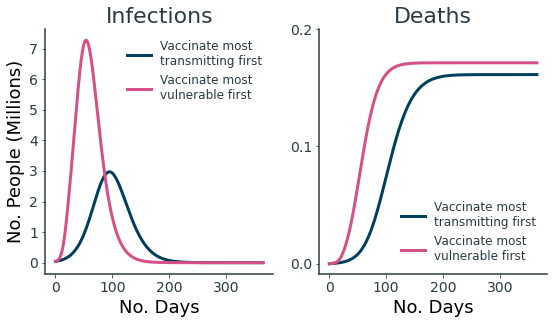

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4.5), sharex=True, sharey=False)
ax = ax.flatten()

ax[0].plot(
    df["Days"], df["Infected"] / 1000000, label="Vaccinate most\ntransmitting first"
)
ax[0].plot(
    df_rev["Days"],
    df_rev["Infected"] / 1000000,
    label="Vaccinate most\nvulnerable first",
)
ax[0].legend()
ax[0].set_title("Infections")

ax[1].plot(
    df["Days"], df["Deaths"] / 1000000, label="Vaccinate most\ntransmitting first"
)
ax[1].plot(
    df_rev["Days"], df_rev["Deaths"] / 1000000, label="Vaccinate most\nvulnerable first"
)
ax[1].legend()
ax[1].set_title("Deaths")
ax[1].set_yticks([0, 0.1, 0.2])

ax[0].set_ylabel("No. People (Millions)")
ax[0].set_xlabel("No. Days")
ax[1].set_xlabel("No. Days")
fig.savefig("../figures/SS_cover.png")